<a href="https://colab.research.google.com/github/dorzv/ComputerVision/blob/master/single_object_detection/Pytorch_Single_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Object Detection Using Pytorch

In the task of object detection, we want to find the location of an object in an image. We may search for one type of object (single-object detection, as in this tutorial) or for multiple objects (multi-object detection). Usually, we define the location of the object using a bounding box. There are several ways to represent a bounding box:

1. The top-left point with width and height - $[x_0, y_0, w, h]$, where $x_0$ is the left side of the box, $y_0$ is the top side of the box, $w$ and $h$ are the width and the height of the box, respectively.

2. The top-left point and bottom-right point - $[x_0, y_0, x_1, y_1]$, where $x_0$ is the left side of the box, $y_0$ is the top side of the box, $x_1$ is the right side of the box, and $y_1$ is the bottom side of the box.

3.  The center point with width and height - $[x_c, y_c, w, h]$, where $x_c$ is the x coordinate of the center of the box, $y_c$ is the y coordinate of the center of the box, $w$ and $h$ are the width and the height of the box, respectively.

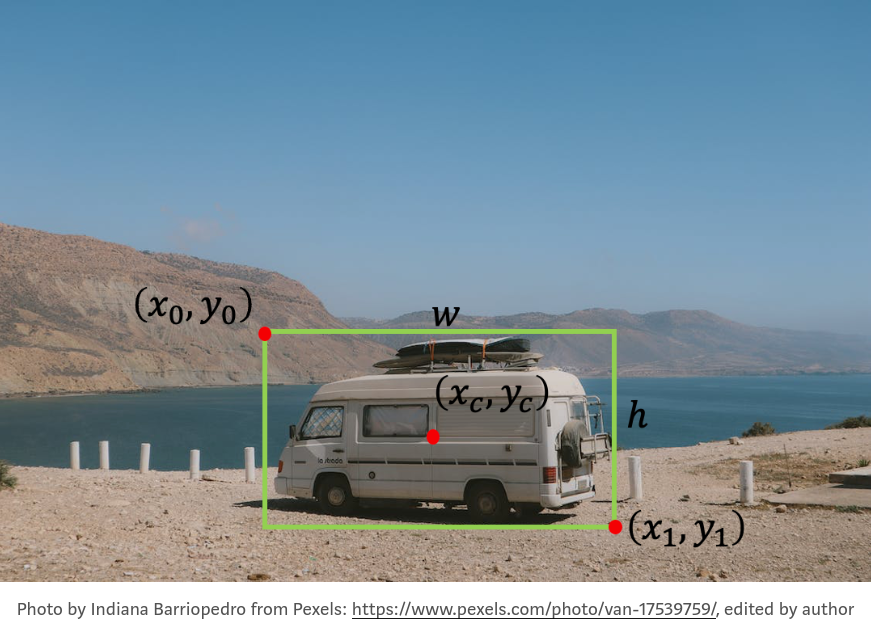

In this tutorial, we focus on finding the center of the [fovea](https://en.wikipedia.org/wiki/Fovea_centralis) in medical eye images from the [iChallenge-AMD](https://amd.grand-challenge.org/) competition.

## Getting the Data
We are going to work with eye images of Age-related Macular degeneration (AMD) patients.

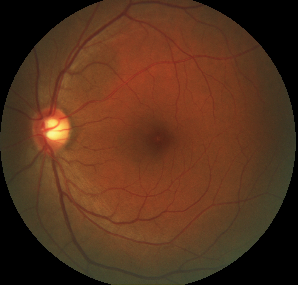

There are two main resources to get the data. The first one is the iChallenge-AMD website https://amd.grand-challenge.org/. You first need to sign up for the competition and then can download the data. The second way does not require signing up, and it is downloading from https://ai.baidu.com/broad/download. Here you need to download "[Training]Images and AMD labels" for the images and "[Training]Disc and fovea annotations" for the Excel file with the labels.

After downloading the data and extracting it, you should have a folder *Training400* with the subfolders *AMD* (with 89 images) and *Non-AMD* (with 311 images) and an Excel file *Fovea_location.xlsx* that contains the center location of the fovea in each image.

## Exploring the Data
Let's start by loading the Excell file using Pandas

In [1]:
! rm -rf Training400

In [2]:
! cp -a drive/MyDrive/Training400 .

In [3]:
from pathlib import Path
import pandas as pd

path_to_parent_dir = Path('.')
path_to_labels_file = path_to_parent_dir / 'Training400' /'Fovea_location.xlsx'

labels_df = pd.read_excel(path_to_labels_file, index_col='ID')

print('Head')
print(labels_df.head())  # show the first 5 rows in the excell file
print('\nTail')
print(labels_df.tail())  # show the last 5 rows in the excell file

Head
      imgName      Fovea_X      Fovea_Y
ID                                     
1   A0001.jpg  1182.264278  1022.018842
2   A0002.jpg   967.754046  1016.946655
3   A0003.jpg  1220.206714   989.944033
4   A0004.jpg  1141.140888  1000.594955
5   A0005.jpg  1127.371832  1071.109440

Tail
       imgName     Fovea_X     Fovea_Y
ID                                    
396  N0307.jpg  823.024991  690.210211
397  N0308.jpg  647.598978  795.653188
398  N0309.jpg  624.571803  755.694880
399  N0310.jpg  687.523044  830.449187
400  N0311.jpg  746.107631  759.623062


We see that the table is composed of four columns:
* ID - which we use as an index for the data frame
* imgName - the name of the images. We notice that images with AMD start with A, while images without AMD start with N
* Fovea_X - the x coordinate of the centroid of the fovea in the image
* Fovea_Y - the y coordinate of the centroid of the fovea in the image

We can plot the centroids of the fovea in the images to understand the distribution of the fovea location.

<Axes: xlabel='Fovea_X', ylabel='Fovea_Y'>

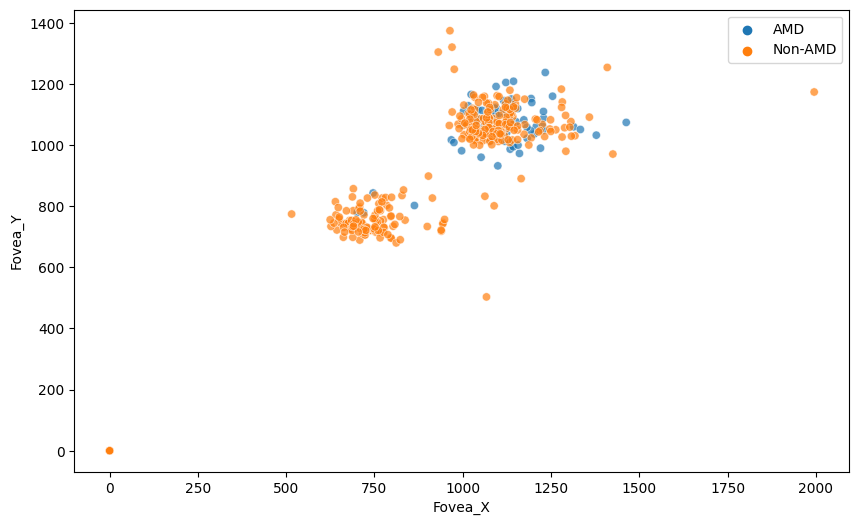

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

amd_or_non_amd = ['AMD' if name.startswith('A') else 'Non-AMD' for name in labels_df.imgName]
sns.scatterplot(x='Fovea_X', y='Fovea_Y', hue=amd_or_non_amd, data=labels_df, alpha=0.7)

We can see two main groups of the fovea location, but the more important thing is that for some images, the label of the fovea centroid is (0, 0). It will be better to remove those images from the data frame.

In [5]:
labels_df = labels_df[(labels_df[['Fovea_X', 'Fovea_Y']] != 0).all(axis=1)]
amd_or_non_amd = ['AMD' if name.startswith('A') else 'Non-AMD' for name in labels_df.imgName]

Now we want to look at a random sample of images and mark the center of the fovea. For that, let's define a function to load an image with its label and another function to draw a bounding box around the fovea according to the label.

In [6]:
import numpy as np
from PIL import Image, ImageDraw

def load_image_with_label(labels_df, id):
  image_name = labels_df.loc[id, 'imgName']
  data_type = 'AMD' if image_name.startswith('A') else 'Non-AMD'
  image_path = path_to_parent_dir / 'Training400' / data_type / image_name
  image = Image.open(image_path)
  label = (labels_df.loc[id, 'Fovea_X'], labels_df.loc[id, 'Fovea_Y'])
  return image, label

def show_image_with_bounding_box(image, label, w_h_bbox=(50, 50), thickness=2):
  w, h = w_h_bbox
  c_x , c_y = label
  image = image.copy()
  ImageDraw.Draw(image).rectangle(((c_x-w//2, c_y-h//2), (c_x+w//2, c_y+h//2)), outline='green', width=thickness)
  plt.imshow(image)

We randomly sample six images and show them.

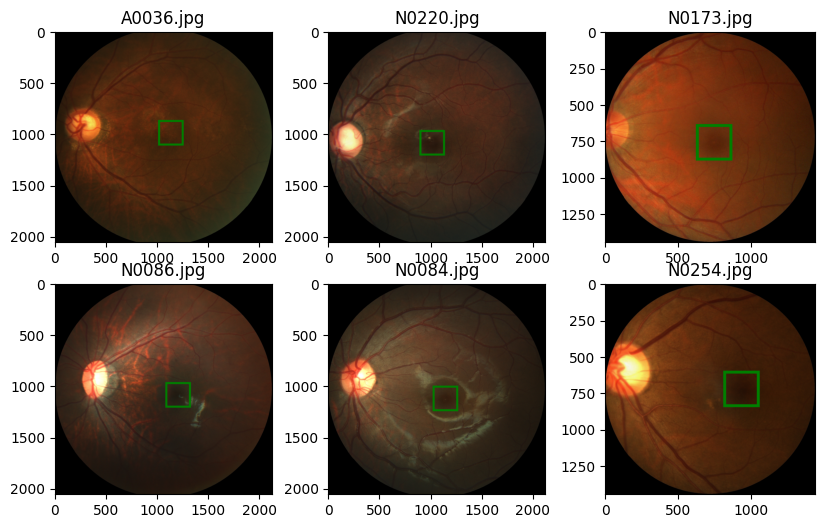

In [7]:
rng = np.random.default_rng(42)  # create Generator object with seed 42
n_rows = 2  # number of rows in the image subplot
n_cols = 3  # # number of cols in the image subplot
indexes = rng.choice(labels_df.index, n_rows * n_cols)

for ii, id in enumerate(indexes, 1):
  image, label = load_image_with_label(labels_df, id)
  plt.subplot(n_rows, n_cols, ii)
  show_image_with_bounding_box(image, label, (250, 250), 20)
  plt.title(labels_df.loc[id, 'imgName'])

The first thing we need to pay attention to from the figure above is that the dimensions of the images are different for different images. We now want to understand the distribution of the image dimensions. For that, we collect the heights and widths of the images in our dataset.

<Axes: ylabel='Count'>

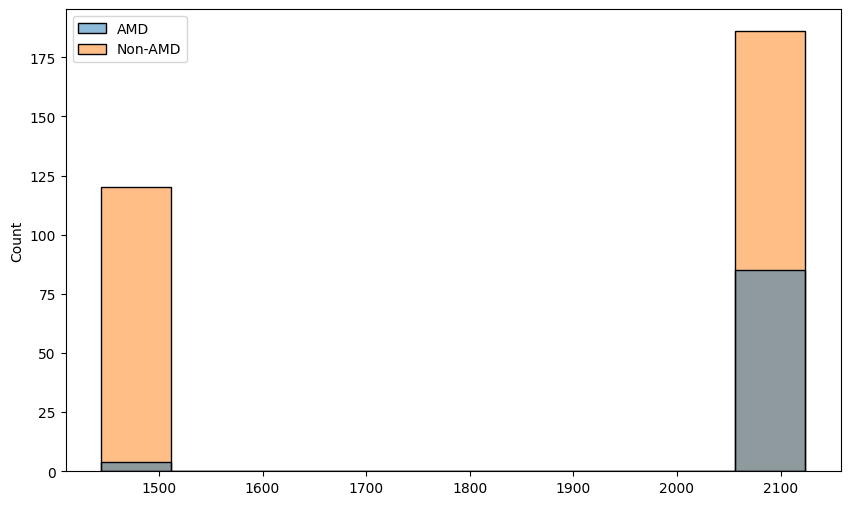

In [8]:
heights = []
widths = []

for image_name, data_type in zip(labels_df['imgName'], amd_or_non_amd):
  image_path = path_to_parent_dir / 'Training400' / data_type / image_name
  h, w = Image.open(image_path).size
  heights.append(h)
  widths.append(w)

sns.histplot(x=heights, hue=amd_or_non_amd)

<Axes: ylabel='Count'>

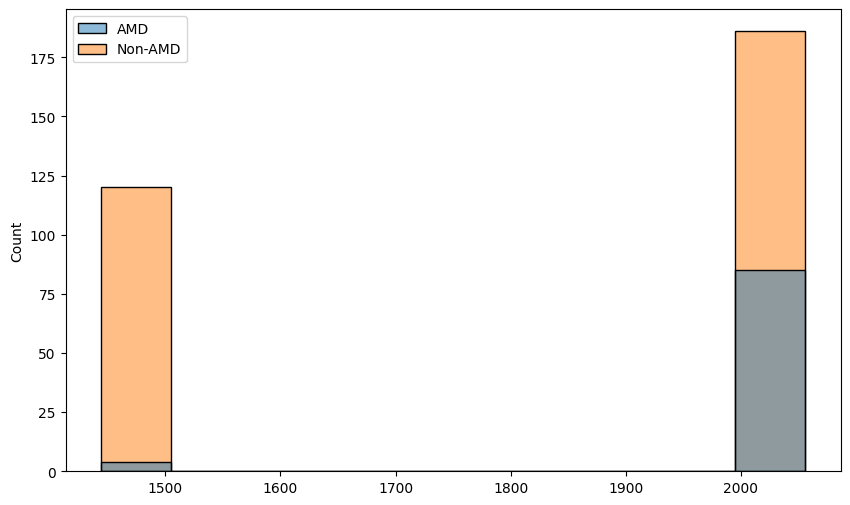

In [9]:
sns.histplot(x=widths, hue=amd_or_non_amd)

## Data Augmentation and Transformation
Data augmentation is a very important step that lets us extend our dataset (especially when we have a small dataset, as in our case) and make the network more robust. We also want to apply some transformations to make the input to the network consistent (in our case, we need to resize the images so they have constant dimensions).

In addition to the augmentation and transformation of the images, we also need to take care of the labels. For example, if we vertically flip an image, the centroid of the fovea will get a new coordinate that we need to update. To update the labels together with the transformation of the image, we are going to write some transformation classes by ourselves.

In [10]:
import torch
import torchvision.transforms.functional as tf

class Resize:
  '''Resize the image and convert the label
     to the new shape of the image'''
  def __init__(self, new_size=(256, 256)):
    self.new_width = new_size[0]
    self.new_height = new_size[1]

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]
    c_x, c_y = label
    original_width, original_height = image.size
    image_new = tf.resize(image, (self.new_width, self.new_height))
    c_x_new = c_x * self.new_width /original_width
    c_y_new = c_y * self.new_height / original_height
    return image_new, (c_x_new, c_y_new)


class RandomHorizontalFlip:
  '''Horizontal flip the image with probability p.
     Adjust the label accordingly'''
  def __init__(self, p=0.5):
    if not 0 <= p <= 1:
      raise ValueError(f'Variable p is a probability, should be float between 0 to 1')
    self.p = p  # float between 0 to 1 represents the probability of flipping

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]
    w, h = image.size
    c_x, c_y = label
    if np.random.random() < self.p:
      image = tf.hflip(image)
      label = w - c_x, c_y
    return image, label


class RandomVerticalFlip:
  '''Vertically flip the image with probability p.
    Adjust the label accordingly'''
  def __init__(self, p=0.5):
    if not 0 <= p <= 1:
      raise ValueError(f'Variable p is a probability, should be float between 0 to 1')
    self.p = p  # float between 0 to 1 represents the probability of flipping

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]
    w, h = image.size
    c_x, c_y = label
    if np.random.random() < self.p:
      image = tf.vflip(image)
      label = c_x, h - c_y
    return image, label


class RandomTranslation:
  '''Translate the image by randomaly amount inside a range of values.
     Translate the label accordingly'''
  def __init__(self, max_translation=(0.2, 0.2)):
    if (not 0 <= max_translation[0] <= 1) or (not 0 <= max_translation[1] <= 1):
      raise ValueError(f'Variable max_translation should be float between 0 to 1')
    self.max_translation_x = max_translation[0]
    self.max_translation_y = max_translation[1]

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]
    w, h = image.size
    c_x, c_y = label
    x_translate = int(np.random.uniform(-self.max_translation_x, self.max_translation_x) * w)
    y_translate = int(np.random.uniform(-self.max_translation_y, self.max_translation_y) * h)
    image = tf.affine(image, translate=(x_translate, y_translate), angle=0, scale=1, shear=0)
    label = c_x + x_translate, c_y + y_translate
    return image, label


class ImageAdjustment:
  '''Change the brightness and contrast of the image and apply Gamma correction.
     No need to change the label.'''
  def __init__(self, p=0.5, brightness_factor=0.8, contrast_factor=0.8, gamma_factor=0.4):
    if not 0 <= p <= 1:
      raise ValueError(f'Variable p is a probability, should be float between 0 to 1')
    self.p = p
    self.brightness_factor = brightness_factor
    self.contrast_factor = contrast_factor
    self.gamma_factor = gamma_factor

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]

    if np.random.random() < self.p:
      brightness_factor = 1 + np.random.uniform(-self.brightness_factor, self.brightness_factor)
      image = tf.adjust_brightness(image, brightness_factor)

    if np.random.random() < self.p:
      contrast_factor = 1 + np.random.uniform(-self.brightness_factor, self.brightness_factor)
      image = tf.adjust_contrast(image, contrast_factor)

    if np.random.random() < self.p:
      gamma_factor = 1 + np.random.uniform(-self.brightness_factor, self.brightness_factor)
      image = tf.adjust_gamma(image, gamma_factor)

    return image, label

class ToTensor:
  '''Convert the image to a Pytorch tensor with
     the channel as first dimenstion and values
     between 0 to 1. Also convert the label to tensor
     with values between 0 to 1'''
  def __init__(self, scale_label=True):
    self.scale_label = scale_label

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1]
    w, h = image.size
    c_x, c_y = label

    image = tf.to_tensor(image)

    if self.scale_label:
      label = c_x/w, c_y/h
    label = torch.tensor(label, dtype=torch.float32)

    return image, label


class ToPILImage:
  '''Convert a tensor image to PIL Image.
     Also convert the label to a tuple with
     values with the image units'''
  def __init__(self, unscale_label=True):
    self.unscale_label = unscale_label

  def __call__(self, image_label_sample):
    image = image_label_sample[0]
    label = image_label_sample[1].tolist()

    image = tf.to_pil_image(image)
    w, h = image.size

    if self.unscale_label:
      c_x, c_y = label
      label = c_x*w, c_y*h

    return image, label


Let's try our new transformation. We create objects for each transformation class and concatenate them using `Compose` from torchvision. Then we apply the full transformation on an image with its label

In [48]:
from torchvision.transforms import Compose
image, label = load_image_with_label(labels_df, 1)
transformation = Compose([Resize(), RandomHorizontalFlip(), RandomVerticalFlip(), RandomTranslation(), ImageAdjustment(), ToTensor()])
new_image, new_label = transformation((image, label))
print(f'new_im type {new_image.dtype}, shape = {new_image.shape}')
print(f'{new_label=}')

new_im type torch.float32, shape = torch.Size([3, 256, 256])
new_label=tensor([0.4238, 0.4971])


We got the results as expected. We also want to transform the new tensor into a PIL image and convert the label back to the image coordinate, so we can show it using our show method.

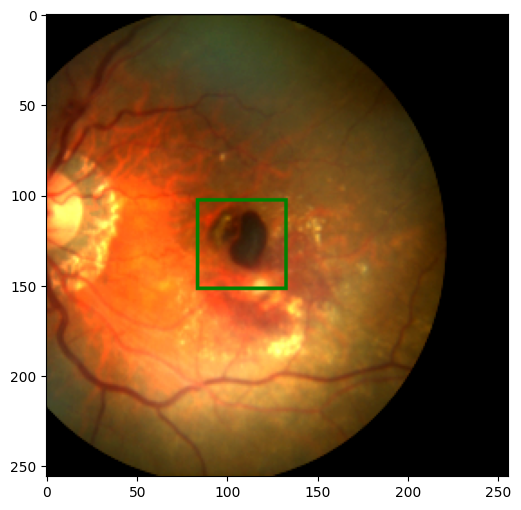

In [49]:
new_image, new_label = ToPILImage()((new_image, new_label))
show_image_with_bounding_box(new_image, new_label)

## Making the Dataset and DataLoader
To load the data into our model, we need first to build a custom Dataset class (which is a subclass of PyTorch Dataset class). For that, we need to implement three methods:
* `__init__()` - to construct and initialize a Dataset object
* `__getitem__()` - that handles the way we can get an image and label from the whole dataset by index
* `__len__()` - that returns the length of the dataset we have

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class AMDDataset(Dataset):
  def __init__(self, data_path, labels_df, transformation):
    self.data_path = Path(data_path)
    self.labels_df = labels_df.reset_index(drop=True)
    self.transformation = transformation

  def __getitem__(self, index):
    image_name = self.labels_df.loc[index, 'imgName']
    image_path = self.data_path / ('AMD' if image_name.startswith('A') else 'Non-AMD') / image_name
    image = Image.open(image_path)
    label = self.labels_df.loc[index, ['Fovea_X','Fovea_Y']].values.astype(float)
    image, label = self.transformation((image, label))
    return image.to(device), label.to(device)

  def __len__(self):
    return len(self.labels_df)

Before we actually create our Dataset objects, we need to split the data into a train set and validation set. We use `scikit-learn` to split the `labels_df` to a train data frame and validation one.

In [14]:
from sklearn.model_selection import train_test_split
labels_df_train, labels_df_val = train_test_split(labels_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
train_transformation = Compose([Resize(), RandomHorizontalFlip(), RandomVerticalFlip(), RandomTranslation(), ImageAdjustment(), ToTensor()])
val_transformation = Compose([Resize(), ToTensor()])

train_dataset = AMDDataset('Training400', labels_df_train, train_transformation)
val_dataset = AMDDataset('Training400', labels_df_val, val_transformation)

We can check our dataset objects by showing a sample of images

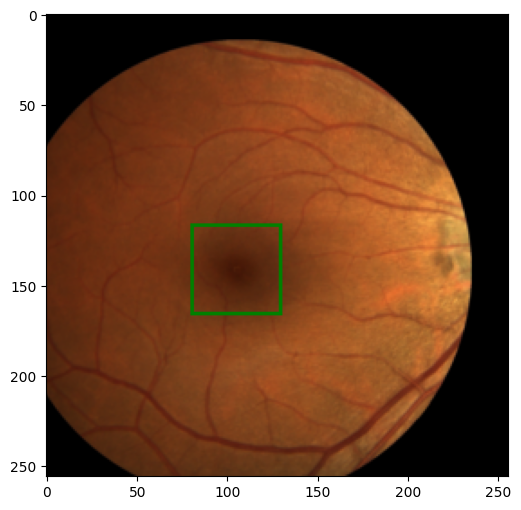

In [16]:
image, label = train_dataset[0]
show_image_with_bounding_box(*(ToPILImage()((image, label))))

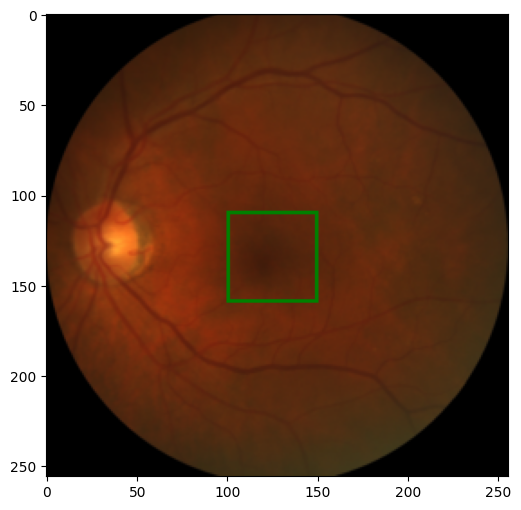

In [17]:
image, label = val_dataset[0]
show_image_with_bounding_box(*(ToPILImage()((image, label))))

The next step is to define a DataLoaders, one for the training dataset and one for the validation dataset.



In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=16)

We don't have to shuffle in the DataLoader since we already shuffle the data when we split it into training and validation datasets. Let's now look at a batch to see that the results are as expected.

In [19]:
image_batch, labels_batch = next(iter(train_dataloader))
print(image_batch.shape, image_batch.dtype)
print(labels_batch, labels_batch.dtype)

torch.Size([8, 3, 256, 256]) torch.float32
tensor([[0.4965, 0.3782],
        [0.6202, 0.6245],
        [0.5637, 0.4887],
        [0.5114, 0.4908],
        [0.3087, 0.4657],
        [0.5330, 0.5309],
        [0.6800, 0.6544],
        [0.5828, 0.4034]], device='cuda:0') torch.float32


## Building the Model
We want to build a model that gets a resized RGB image and returns two values for the $x$ and $y$ coordinates. We are going to use residual blocks in a similar way to ResNet using a skip connection. We start by defining the basic res-block

In [20]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn

class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.base1 = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(True)
    )
    self.base2 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

  def forward(self, x):
    x = self.base1(x) + x
    x = self.base2(x)
    return x

This block has two steps. First, it uses a convolution layer followed by batch normalization and ReLU. Then we add the original input to the result and apply the second step, which again consists of a convolution layer followed by batch normalization and ReLU, but this time we change the number of filters. Now we are ready to build the model.

In [21]:
class FoveaNet(nn.Module):
  def __init__(self, in_channels, first_output_channels):
    super().__init__()
    self.model = nn.Sequential(
        ResBlock(in_channels, first_output_channels),
        nn.MaxPool2d(2),
        ResBlock(first_output_channels, 2 * first_output_channels),
        nn.MaxPool2d(2),
        ResBlock(2 * first_output_channels, 4 * first_output_channels),
        nn.MaxPool2d(2),
        ResBlock(4 * first_output_channels, 8 * first_output_channels),
        nn.MaxPool2d(2),
        nn.Conv2d(8 * first_output_channels, 16 * first_output_channels, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(7 * 7 * 16 * first_output_channels, 2)
    )

  def forward(self, x):
    return self.model(x)

We can better see our model using `torchinfo` package

In [22]:
! pip install torchinfo -q

In [23]:
from torchinfo import summary
net = FoveaNet(3, 16)

summary(model=net,
        input_size=(8, 3, 256, 256), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #
FoveaNet (FoveaNet)                      [8, 3, 256, 256]     [8, 2]               --
├─Sequential (model)                     [8, 3, 256, 256]     [8, 2]               --
│    └─ResBlock (0)                      [8, 3, 256, 256]     [8, 16, 256, 256]    --
│    │    └─Sequential (base1)           [8, 3, 256, 256]     [8, 3, 256, 256]     90
│    │    └─Sequential (base2)           [8, 3, 256, 256]     [8, 16, 256, 256]    480
│    └─MaxPool2d (1)                     [8, 16, 256, 256]    [8, 16, 128, 128]    --
│    └─ResBlock (2)                      [8, 16, 128, 128]    [8, 32, 128, 128]    --
│    │    └─Sequential (base1)           [8, 16, 128, 128]    [8, 16, 128, 128]    2,352
│    │    └─Sequential (base2)           [8, 16, 128, 128]    [8, 32, 128, 128]    4,704
│    └─MaxPool2d (3)                     [8, 32, 128, 128]    [8, 32, 64, 64]      --
│    └─ResBlock (4)                      [

## Loss and Optimizer
We start by defining the loss function using the [smooth L1 loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). In general, this loss behaves like L2 when the absolute difference is less than 1, and like L1 otherwise.

In [24]:
loss_func = nn.SmoothL1Loss()

For the optimizer, we are going to use Adam.

In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

As a performance metric, we utilize the Intersection over Union metric (IoU). This metric calculates the ratio between the intersection of two bounding boxes and their union.

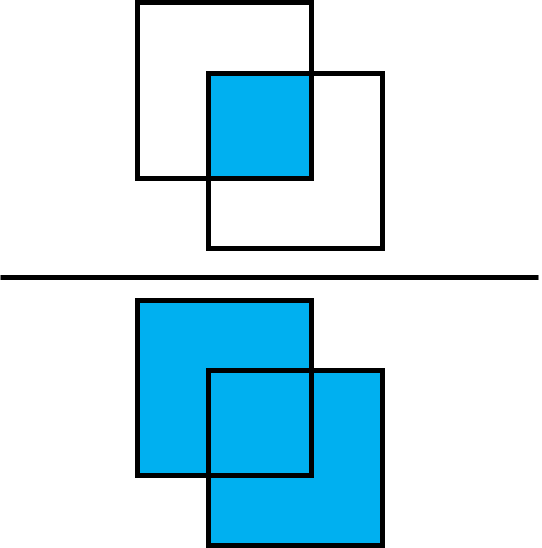

First, we need to define a function that gets centroids as input and returns the bounding box of the form $[x_0, y_0, x_1, y_1]$ as output

In [26]:
def centroid_to_bbox(centroids, w=50/256, h=50/256):
  x0_y0 = centroids - torch.tensor([w/2, h/2]).to(device)
  x1_y1 = centroids + torch.tensor([w/2, h/2]).to(device)
  return torch.cat([x0_y0, x1_y1], dim=1)

and a function to compute the IoU for a batch of labels

In [27]:
from torchvision.ops import box_iou
def iou_batch(output_labels, target_labels):
  output_bbox = centroid_to_bbox(output_labels)
  target_bbox = centroid_to_bbox(target_labels)
  return torch.trace(box_iou(output_bbox, target_bbox)).item()

Next, we define a loss function for a batch

In [28]:
def batch_loss(loss_func, output, target, optimizer=None):
  loss = loss_func(output, target)
  with torch.no_grad():
    iou_metric = iou_batch(output, target)
  if optimizer is not None:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss.item(), iou_metric

## Training the Model


In this step, we are going to train our model to find the fovea. We start by defining a helper function to make a training step, which means going over all the data in a Dataloader, getting the loss (and updating the weights in the training case) using our previous function `batch_loss`, and track the loss and IoU metric.

In [29]:
def train_val_step(dataloader, model, loss_func, optimizer=None):
  if optimizer is not None:
    model.train()
  else:
    model.eval()

  running_loss = 0
  running_iou = 0

  for image_batch, label_batch in dataloader:
    output_labels = model(image_batch)
    loss_value, iou_metric_value = batch_loss(loss_func, output_labels, label_batch, optimizer)
    running_loss += loss_value
    running_iou += iou_metric_value

  return running_loss/len(dataloader.dataset), running_iou/len(dataloader.dataset)


Now we have all we need to perform the training. We define two dictionaries to track the loss and IoU metric for the training and validation after each epoch. We also save the weights of the model that give the best result.

In [30]:
num_epoch = 100
loss_tracking = {'train': [], 'val': []}
iou_tracking = {'train': [], 'val': []}
best_loss = float('inf')

model = FoveaNet(3, 16).to(device)
loss_func = nn.SmoothL1Loss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


for epoch in range(num_epoch):
  print(f'Epoch {epoch+1}/{num_epoch}')

  training_loss, trainig_iou = train_val_step(train_dataloader, model, loss_func, optimizer)
  loss_tracking['train'].append(training_loss)
  iou_tracking['train'].append(trainig_iou)

  with torch.inference_mode():
    val_loss, val_iou = train_val_step(val_dataloader, model, loss_func, None)
    loss_tracking['val'].append(val_loss)
    iou_tracking['val'].append(val_iou)
    if val_loss < best_loss:
      print('Saving best model')
      torch.save(model.state_dict(), 'best_model.pt')
      best_loss = val_loss

  print(f'Training loss: {training_loss:.6}, IoU: {trainig_iou:.2}')
  print(f'Validation loss: {val_loss:.6}, IoU: {val_iou:.2}')

Epoch 1/100
Saving best model
Training loss: 0.0738945, IoU: 0.081
Validation loss: 0.00696153, IoU: 0.25
Epoch 2/100
Training loss: 0.0443535, IoU: 0.11
Validation loss: 0.0236645, IoU: 0.15
Epoch 3/100
Training loss: 0.0346667, IoU: 0.14
Validation loss: 0.0102532, IoU: 0.26
Epoch 4/100
Training loss: 0.0256568, IoU: 0.17
Validation loss: 0.00824633, IoU: 0.29
Epoch 5/100
Training loss: 0.019582, IoU: 0.2
Validation loss: 0.0152919, IoU: 0.19
Epoch 6/100
Training loss: 0.0185006, IoU: 0.21
Validation loss: 0.00943595, IoU: 0.29
Epoch 7/100
Training loss: 0.0210649, IoU: 0.16
Validation loss: 0.0180787, IoU: 0.14
Epoch 8/100
Training loss: 0.0174296, IoU: 0.2
Validation loss: 0.0108028, IoU: 0.25
Epoch 9/100
Training loss: 0.0173657, IoU: 0.2
Validation loss: 0.0157334, IoU: 0.25
Epoch 10/100
Training loss: 0.0174585, IoU: 0.2
Validation loss: 0.0106731, IoU: 0.24
Epoch 11/100
Training loss: 0.0205446, IoU: 0.17
Validation loss: 0.01035, IoU: 0.27
Epoch 12/100
Training loss: 0.0189017

Let's plot the average loss per epoch and the average IoU as a function of the epochs.

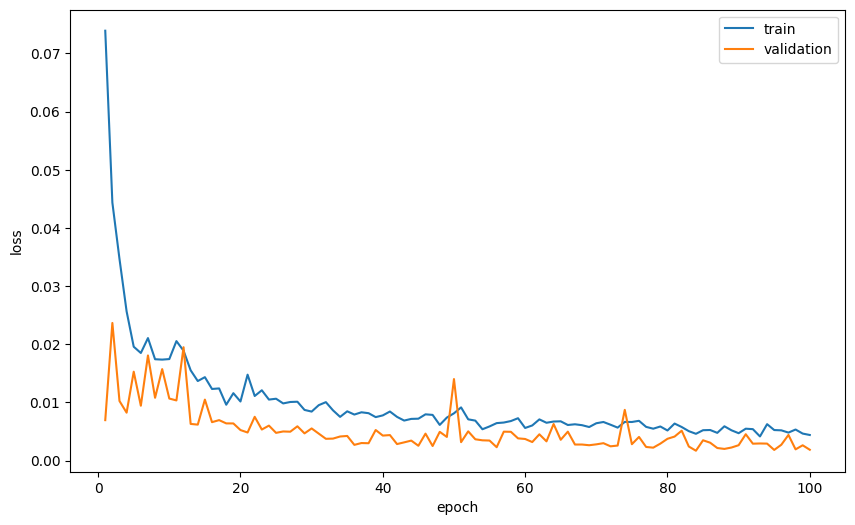

In [31]:
plt.plot(range(1, num_epoch+1), loss_tracking['train'], label='train')
plt.plot(range(1, num_epoch+1), loss_tracking['val'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

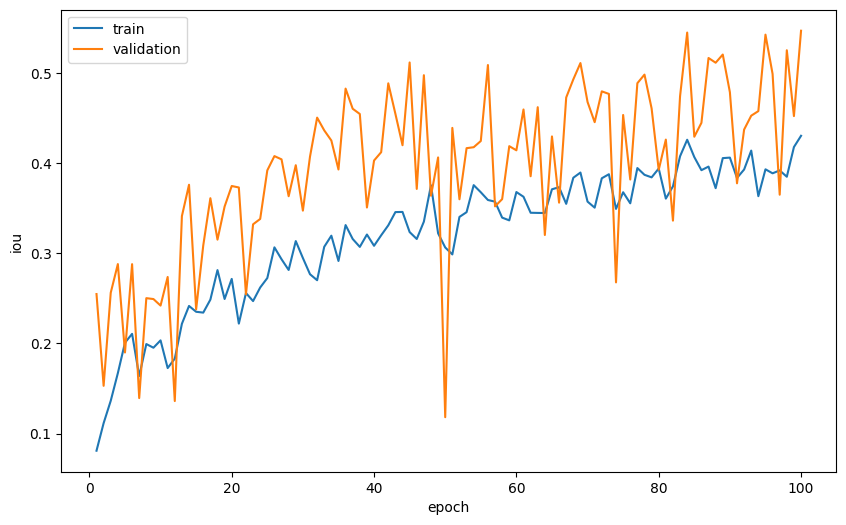

In [32]:
plt.plot(range(1, num_epoch+1), iou_tracking['train'], label='train')
plt.plot(range(1, num_epoch+1), iou_tracking['val'], label='validation')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.legend()

Finally, we want to look at some images and see how much the prediction of the model is close to the real coordinates of the fovea. For that, we define a new function based on our previous function, `show_image_with_bounding_box`, but this time we draw the bounding box for the prediction (in green) as well as for the target (in red).

In [33]:
def show_image_with_2_bounding_box(image, label, target_label, w_h_bbox=(50, 50), thickness=2):
  w, h = w_h_bbox
  c_x , c_y = label
  c_x_target , c_y_target = target_label
  image = image.copy()
  ImageDraw.Draw(image).rectangle(((c_x-w//2, c_y-h//2), (c_x+w//2, c_y+h//2)), outline='green', width=thickness)
  ImageDraw.Draw(image).rectangle(((c_x_target-w//2, c_y_target-h//2), (c_x_target+w//2, c_y_target+h//2)), outline='red', width=thickness)
  plt.imshow(image)

and now we load the best model we got and make prediction on a sample of images and look at the results

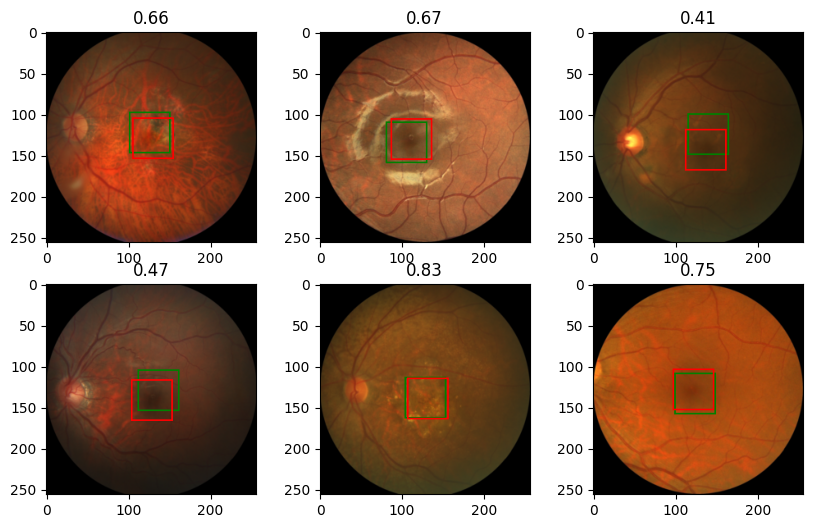

In [46]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
rng = np.random.default_rng(0)  # create Generator object with seed 42
n_rows = 2  # number of rows in the image subplot
n_cols = 3  # # number of cols in the image subplot
indexes = rng.choice(range(len(val_dataset)), n_rows * n_cols, replace=False)

for ii, id in enumerate(indexes, 1):
  image, label = val_dataset[id]
  output = model(image.unsqueeze(0))
  iou = iou_batch(output, label.unsqueeze(0))
  _, label = ToPILImage()((image, label))
  image, output = ToPILImage()((image, output.squeeze()))
  plt.subplot(n_rows, n_cols, ii)
  show_image_with_2_bounding_box(image, output, label)
  plt.title(f'{iou:.2f}')